# Lasso

- Estimate the female literacy rate in India using a LASSO model. 
- Replicate the results from the script developed in Lab 4 in Python, R, and Julia. 
- The data is available at CausalAI-Course/Data/Districtwise_literacy_rates.xlsx. 
- To consult the description of each variable, please review Sheet 2 (Metadata) of the same file. 
- You are free to select the variables you consider relevant for your models.

## 1. Load data

In [3]:
import pandas as pd

# Path to your Excel file
file_path = "Districtwise_literacy_rates.xlsx"

# Load the first sheet (usually contains the data)
df = pd.read_excel(file_path, sheet_name=0)

## 2. Keep only the observations with no missing values

In [10]:
df_clean = df.dropna(axis=0, how="any").copy()

print("Original rows:", df.shape[0])
print("Rows after dropping missing values:", df_clean.shape[0])

Original rows: 680
Rows after dropping missing values: 625


## 3. Create a histogram of the female and male literacy rate and comment briefly on its distribution.

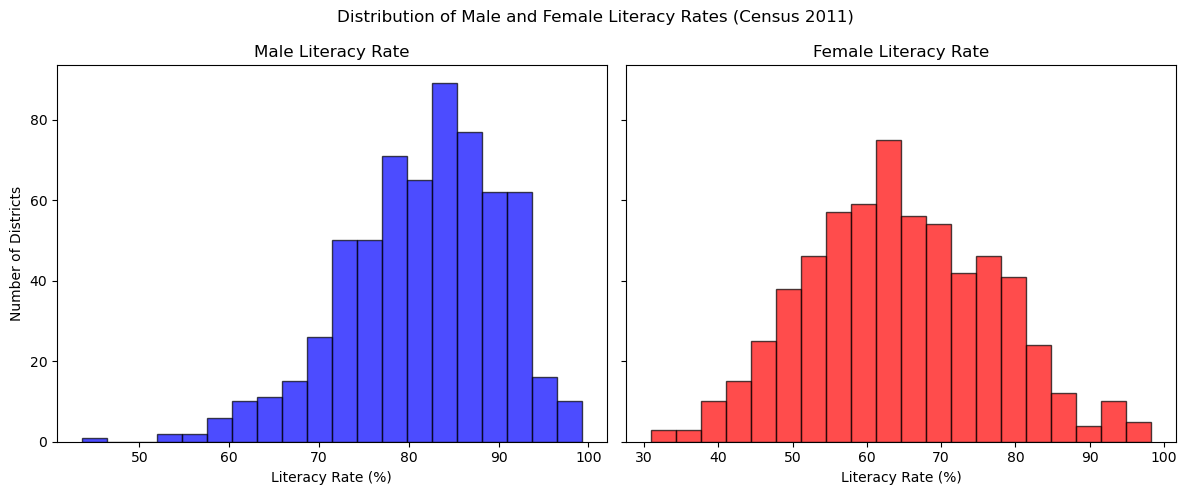

In [15]:
import pandas as pd
import matplotlib.pyplot as plt   

# Identify column names
male_col = "MALE_LIT"
female_col = "FEMALE_LIT"

# Extract series
male_lit = df_clean[male_col]
female_lit = df_clean[female_col]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

axes[0].hist(male_lit, bins=20, color="blue", edgecolor="black", alpha=0.7)
axes[0].set_title("Male Literacy Rate")
axes[0].set_xlabel("Literacy Rate (%)")
axes[0].set_ylabel("Number of Districts")

axes[1].hist(female_lit, bins=20, color="red", edgecolor="black", alpha=0.7)
axes[1].set_title("Female Literacy Rate")
axes[1].set_xlabel("Literacy Rate (%)")

plt.suptitle("Distribution of Male and Female Literacy Rates (Census 2011)")
plt.tight_layout()
plt.show()

**Comment:**

**Male Literacy Rate**

- The histogram is concentrated in the higher range (≈75–95%).

- It looks roughly bell-shaped but skewed a bit left, meaning most districts have high male literacy, with fewer at the low end.

- This shows relatively less variation among districts.

**Female Literacy Rate**

- The distribution is shifted to the left (≈50–80%), clearly lower than for males.

- There is a wider spread, with some districts below 40% female literacy, showing larger disparities.

**👉 In short:** male literacy is consistently higher and tightly clustered, while female literacy is more dispersed, highlighting the gender gap in literacy across districts in India.

## 4. Estimate a low-dimensional specification and compute the (R^2) on the test set

In the low-dimensional specification, I restricted the model to a core set of five demographic and socio-economic predictors: 

- 1) Total population (TOTPOPULAT): Larger districts may face higher demand for schooling, potentially stretching resources.

- 2) Percentage of urban population (P_URB_POP): Urban areas typically have better access to schools, infrastructure, and educational services, which can raise female literacy relative to rural areas.

- 3) Sex ratio (SEXRATIO): The balance between men and women in the population reflects social norms and gender dynamics; skewed ratios can indicate environments where women’s opportunities are constrained, including in education.  

- 4) Percentage of Scheduled Castes (P_SC_POP): Scheduled Castes have historically faced social and economic disadvantages; a higher share may be linked to structural barriers in literacy, especially for women.

- 5) Percentage of Scheduled Tribes (P_ST_POP): Scheduled Tribes often live in remote areas with limited school access; their presence captures geographic and cultural challenges to achieving higher female literacy. 

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split   
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Target variable
y = df_clean["FEMALE_LIT"]

# --- Low-dimensional specification ---
# Few key predictors (demographic + socio-economic)
X = df_clean[[
    "TOTPOPULAT",   # population size
    "P_URB_POP",    # % urban
    "SEXRATIO",     # sex ratio
    "P_SC_POP",     # % Scheduled Castes
    "P_ST_POP"      # % Scheduled Tribes
]]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Fit simple linear regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict and compute R^2
y_pred = linreg.predict(X_test)
r2 = r2_score(y_test, y_pred)

print("Low-dimensional specification:")
print("Predictors:", list(X.columns))
print(f"R^2 on test set: {r2:.4f}")

Low-dimensional specification:
Predictors: ['TOTPOPULAT', 'P_URB_POP', 'SEXRATIO', 'P_SC_POP', 'P_ST_POP']
R^2 on test set: 0.2199


## 5. Estimate a high-dimensional (flexible) specification: interaction terms and squared terms and compute the (R^2) on the test set

We will conduct the LASSO exercise in a high-dimensional setting using three alternative model specifications. 
- **Alternative 1** This specification keeps a small, theory-driven core of predictors (population, urbanization, sex ratio, SC/ST shares, area) and makes the model flexible by adding all second-order terms (squares) and all pairwise interactions among them. <br><br>

- **Alternative 2** This specification enriches the core demographics with education supply, access, and quality measures, and only adds nonlinearities and interactions that have clear economic meaning. <br><br>

- **Alternative 3** This specification takes the widest approach: it includes all variables (that make economic sense). In addition, it extends the model by adding squared terms and a set of key interactions.

Having these three alternatives is useful because they allow us to compare different modeling strategies under LASSO. Alternative 1 provides a clean benchmark that is simple but flexible, showing the effect of adding pure polynomial expansions to a small set of core variables. Alternative 2 strikes a balance by focusing on variables and nonlinearities that are economically meaningful, avoiding unnecessary complexity. Alternative 3 pushes the model to its widest scope, including almost every plausible variable.

### Alternative 1

- Inputs (base): TOTPOPULAT, P_URB_POP, SEXRATIO, P_SC_POP, P_ST_POP, AREA_SQKM.

- Feature engineering: PolynomialFeatures(degree=2, include_bias=False) → adds squares (e.g., P_URB_POP², AREA_SQKM²) and all pairwise interactions (e.g., P_URB_POP × SEXRATIO).

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

# --- Target and predictors (adjust if needed) ---
target = "FEMALE_LIT"
predictors = [
    "TOTPOPULAT",  # population size
    "P_URB_POP",   # % urban population
    "SEXRATIO",    # sex ratio
    "P_SC_POP",    # % Scheduled Castes
    "P_ST_POP",    # % Scheduled Tribes
    "AREA_SQKM"    # area (km^2)
]

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# --- High-dimensional (flexible) model: degree=2 (squares + pairwise interactions) ---
model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("ols", LinearRegression())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

n_in = X_train.shape[1]
n_out = model.named_steps["poly"].n_output_features_

print("High-dimensional (flexible) specification:")
print(f"- Base predictors ({n_in}): {predictors}")
print(f"- Expanded features (degree=2: squares + interactions): {n_out}")
print(f"- Test R^2: {r2:.4f}")

High-dimensional (flexible) specification:
- Base predictors (5): ['TOTPOPULAT', 'P_URB_POP', 'SEXRATIO', 'P_SC_POP', 'P_ST_POP', 'AREA_SQKM']
- Expanded features (degree=2: squares + interactions): 20
- Test R^2: 0.2401


### Alternative 2 (Smarter)

Base drivers: 
- TOTPOPULAT, P_URB_POP, SEXRATIO, P_SC_POP, P_ST_POP, AREA_SQKM.

Education:
- Levels: SCHTOT, TCHTOT, CLSTOT.
- Access/coverage: pop_density, schools_per_100k, schools_per_100sqkm.
- Capacity/quality: teachers_per_school, classrooms_per_school, elec_share, comp_share, small_enrol_share.

Selected squared terms (nonlinearities where plausible):
- P_URB_POP², schools_per_100k², teachers_per_school², elec_share², comp_share², pop_density²

Selected interactions:
- P_URB_POP × elec_share, P_URB_POP × comp_share → access × quality/technology.
- P_URB_POP × P_SC_POP, P_URB_POP × SEXRATIO → modernization × social barriers.
- P_ST_POP × AREA_SQKM → tribal isolation in large/remote districts.
- schools_per_100k × teachers_per_school and teachers_per_school × comp_share → capacity × staffing/tech.
- small_enrol_share × AREA_SQKM and pop_density × schools_per_100sqkm → dispersion and demand–supply balance.

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

# ===== 1) BASE VARIABLES (demographics & geography) =====
# Core drivers we will keep:
base_cols = [
    "FEMALE_LIT",  # target
    "TOTPOPULAT",  # population (in thousands per metadata)
    "P_URB_POP",   # % urban
    "SEXRATIO",    # sex ratio
    "P_SC_POP",    # % Scheduled Castes
    "P_ST_POP",    # % Scheduled Tribes
    "AREA_SQKM"    # area (sq km)
]

# ===== 2) EDUCATION INFRASTRUCTURE (aggregate them) =====
# Sum teachers, classrooms, electricity, computers, small-enrolment across categories
def sum_prefix(df, prefix, start, end):
    cols = [f"{prefix}{i}" for i in range(start, end + 1)]
    cols = [c for c in cols if c in df.columns]
    return df[cols].sum(axis=1)

# Totals
dfm = df_clean.copy()
dfm["SCHTOT"]   = dfm["SCHTOT"] if "SCHTOT" in dfm.columns else sum_prefix(dfm, "SCH", 1, 9)
dfm["TCHTOT"]   = sum_prefix(dfm, "TCH", 1, 7)
dfm["CLSTOT"]   = sum_prefix(dfm, "CLS", 1, 7)
dfm["SELETOT"]  = sum_prefix(dfm, "SELE", 1, 7)
dfm["SCOMPTOT"] = sum_prefix(dfm, "SCOMP", 1, 7)
dfm["ENR50TOT"] = sum_prefix(dfm, "ENR50", 1, 9)

# ===== 3) DERIVED, ECONOMICALLY-MEANINGFUL FEATURES =====
# Population is in thousands -> convert to persons for densities
pop_persons = dfm["TOTPOPULAT"] * 1_000

# Handle division safely
def safe_div(a, b):
    out = a.astype(float) / b.astype(float)
    out = out.replace([np.inf, -np.inf], np.nan)
    return out

# Access & capacity measures
dfm["pop_density"]            = safe_div(pop_persons, dfm["AREA_SQKM"])                # people per sq km
dfm["schools_per_100k"]       = safe_div(dfm["SCHTOT"], (pop_persons / 100_000))       # schools per 100k people
dfm["schools_per_100sqkm"]    = safe_div(dfm["SCHTOT"], (dfm["AREA_SQKM"] / 100))      # schools per 100 sq km
dfm["teachers_per_school"]    = safe_div(dfm["TCHTOT"], dfm["SCHTOT"])                 # avg teachers per school
dfm["classrooms_per_school"]  = safe_div(dfm["CLSTOT"], dfm["SCHTOT"])                 # avg classrooms per school
dfm["elec_share"]             = safe_div(dfm["SELETOT"], dfm["SCHTOT"])                # share schools w/ electricity
dfm["comp_share"]             = safe_div(dfm["SCOMPTOT"], dfm["SCHTOT"])               # share schools w/ computers
dfm["small_enrol_share"]      = safe_div(dfm["ENR50TOT"], dfm["SCHTOT"])               # share schools with ≤50 students

# ===== 4) SELECTED NONLINEAR (SQUARED) TERMS where diminishing/accelerating effects make sense =====
for col in [
    "P_URB_POP",
    "schools_per_100k",
    "teachers_per_school",
    "elec_share",
    "comp_share",
    "pop_density"
]:
    dfm[f"{col}__sq"] = dfm[col] ** 2

# ===== 5) SELECTED INTERACTIONS that reflect joint constraints/complementarities =====
def inter(a, b):
    name = f"{a}__x__{b}"
    dfm[name] = dfm[a] * dfm[b]
    return name

interaction_terms = []
interaction_terms += [inter("P_URB_POP", "elec_share")]           # access × quality
interaction_terms += [inter("P_URB_POP", "comp_share")]           # access × technology
interaction_terms += [inter("P_URB_POP", "P_SC_POP")]             # urbanization benefit vs SC disadvantage
interaction_terms += [inter("P_URB_POP", "SEXRATIO")]             # modernization vs gender norms
interaction_terms += [inter("P_ST_POP", "AREA_SQKM")]             # isolation of ST in large/remotely spread districts
interaction_terms += [inter("schools_per_100k", "teachers_per_school")]  # capacity × staffing quality
interaction_terms += [inter("teachers_per_school", "comp_share")]       # teacher capacity × tech resources
interaction_terms += [inter("small_enrol_share", "AREA_SQKM")]          # small schools more binding in dispersed areas
interaction_terms += [inter("pop_density", "schools_per_100sqkm")]      # service density vs population density

# Build final feature list
predictors = [
    # Baseline
    "TOTPOPULAT", "P_URB_POP", "SEXRATIO", "P_SC_POP", "P_ST_POP", "AREA_SQKM",
    # Education infra & derived
    "SCHTOT", "TCHTOT", "CLSTOT",
    "pop_density", "schools_per_100k", "schools_per_100sqkm",
    "teachers_per_school", "classrooms_per_school",
    "elec_share", "comp_share", "small_enrol_share",
    # Squared terms
    "P_URB_POP__sq", "schools_per_100k__sq", "teachers_per_school__sq",
    "elec_share__sq", "comp_share__sq", "pop_density__sq",
] + interaction_terms

# ===== 6) CLEAN rows for this model and split =====
needed_cols = ["FEMALE_LIT"] + predictors
dfm_model = dfm[needed_cols].replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any").copy()

X = dfm_model[predictors]
y = dfm_model["FEMALE_LIT"].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# ===== 7) SCALE + OLS (you could swap OLS for LASSO if you want shrinkage) =====
model = Pipeline([
    ("scaler", StandardScaler()),
    ("ols", LinearRegression())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"Smarter high-dimensional model")
print(f"- n_features: {X_train.shape[1]}")
print(f"- Test R^2: {r2:.4f}")

Smarter high-dimensional model
- n_features: 32
- Test R^2: 0.5174


### Alternative 3 (+ Coefficients)

- Scope: Start with all raw variables from demographics, geography, and education infrastructure.

- Nonlinear terms (squares): P_URB_POP², SEXRATIO², P_SC_POP², P_ST_POP², TOTPOPULAT², AREA_SQKM².

- Selected interactions (economic rationale):
- P_URB_POP × SEXRATIO → modernization vs. gender norms.
- P_URB_POP × P_SC_POP → urbanization vs. caste disadvantage.
- P_URB_POP × P_ST_POP → urbanization vs. tribal isolation.
- SELE2 × SCOMP2 → electricity and computers as complementary resources.
- CLS2 × TCH2 → classrooms and teachers as joint capacity

In [30]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

TARGET = "FEMALE_LIT"

# ===========================================================
# 1) Variables base (demografía + educación)
# ===========================================================
demographic = [
    "TOTPOPULAT","P_URB_POP","POPULATION_0_6","GROWTHRATE","SEXRATIO",
    "P_SC_POP","P_ST_POP","AREA_SQKM","TOT_6_10_15","TOT_11_13_15"
]

sch_gov      = ["SCH2G","SCH3G","SCH4G","SCH5G","SCH6G","SCH7G"]
sch_priv     = ["SCH2P","SCH3P","SCH4P","SCH5P","SCH6P","SCH7P"]
sch_gov_rur  = ["SCH2GR","SCH3GR","SCH4GR","SCH5GR","SCH6GR","SCH7GR"]
sch_priv_rur = ["SCH2PR","SCH3PR","SCH4PR","SCH5PR","SCH6PR","SCH7PR"]

sele   = ["SELE2","SELE3","SELE4","SELE5","SELE6","SELE7"]
scomp  = ["SCOMP2","SCOMP3","SCOMP4","SCOMP5","SCOMP6","SCOMP7"]
enr50  = ["ENR502","ENR503","ENR504","ENR505","ENR506","ENR507"]
cls    = ["CLS2","CLS3","CLS4","CLS5","CLS6","CLS7"]
tch    = ["TCH2","TCH3","TCH4","TCH5","TCH6","TCH7"]

base_predictors = (
    demographic
    + sch_gov + sch_priv + sch_gov_rur + sch_priv_rur
    + sele + scomp + enr50 + cls + tch
)

existing = [c for c in base_predictors if c in df_clean.columns]
missing = [c for c in base_predictors if c not in df_clean.columns]
if missing:
    print("[warning] Missing variables skipped:", missing)

dfm = df_clean[[TARGET] + existing].copy()

# ===========================================================
# 2) Crear términos no lineales (squares)
# ===========================================================
squares = [
    "P_URB_POP",        # urbanización con rendimientos decrecientes
    "SEXRATIO",         # posible efecto no lineal de balance de género
    "P_SC_POP",         # efecto no lineal de SC
    "P_ST_POP",         # efecto no lineal de ST
    "TOTPOPULAT",       # tamaño poblacional
    "AREA_SQKM"         # área distrital
]
for col in squares:
    if col in dfm.columns:
        dfm[f"{col}__sq"] = dfm[col] ** 2

# ===========================================================
# 3) Crear interacciones clave
# ===========================================================
interactions = [
    ("P_URB_POP", "SEXRATIO"),       # urbanización × normas de género
    ("P_URB_POP", "P_SC_POP"),       # urbanización × castas
    ("P_URB_POP", "P_ST_POP"),       # urbanización × tribus
    ("SELE2", "SCOMP2"),             # electricidad × computadoras
    ("CLS2", "TCH2"),                # aulas × docentes (capacidad conjunta)
]

for a, b in interactions:
    if a in dfm.columns and b in dfm.columns:
        dfm[f"{a}__x__{b}"] = dfm[a] * dfm[b]

# ===========================================================
# 4) Definir X, y
# ===========================================================
predictors = [c for c in dfm.columns if c != TARGET]
X = dfm[predictors]
y = dfm[TARGET].astype(float)

# ===========================================================
# 5) Split y modelo
# ===========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

model = Pipeline([
    ("scaler", StandardScaler()),
    ("ols", LinearRegression())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print("\n=== Wide model with squares + selected interactions ===")
print(f"n_features: {X_train.shape[1]}")
print(f"Test R^2: {r2:.4f}")


=== Wide model with squares + selected interactions ===
n_features: 75
Test R^2: 0.5079


**Comment:**

The three alternatives all achieve higher predictive performance than the low-dimensional baseline (R² = 0.2199).

Alternative 1: R² = 0.2401 – Extends the small core model with polynomial terms and interactions, yielding only a modest improvement.

Alternative 2: R² = 0.5174 – Achieves the best fit by carefully selecting economically meaningful variables and adding targeted nonlinearities.

Alternative 3: R² = 0.5079 – Uses a very broad set of variables, including squares and interactions, but performs slightly worse than Alternative 2.

This comparison highlights that thoughtful variable selection (Alternative 2) outperforms simply expanding the feature space indiscriminately (Alternative 3).

## 6. For λ ranging from 10,000 down to 0.001, plot the path of the number of nonzero coefficients and briefly comment on the result.

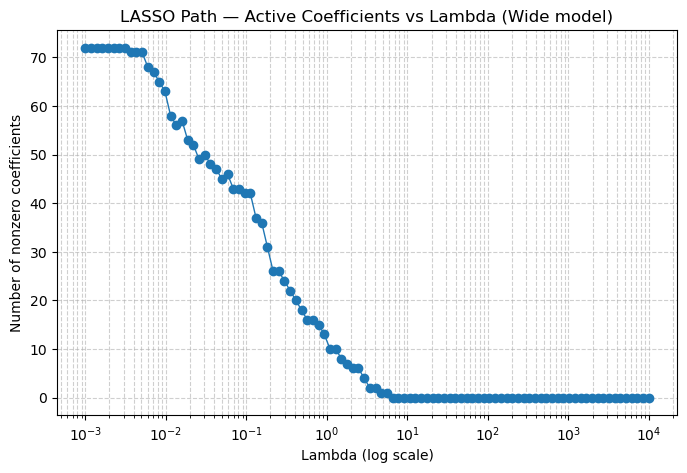

Total candidate features: 75
Nonzeros at λ=10000: 0
Nonzeros at λ=0.001: 72


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# 6.1 Estandarizar con los datos de entrenamiento
scaler = StandardScaler()
Xtr = scaler.fit_transform(X_train)
Xte = scaler.transform(X_test)  # (no imprescindible para el gráfico, útil si luego quieres evaluar)

# 6.2 Grid de lambdas: 10,000 → 0.001 (escala log)
lambdas = np.logspace(4, -3, 100)

nonzeros = []
for lam in lambdas:
    lasso = Lasso(alpha=lam, max_iter=20000, tol=1e-3, fit_intercept=True, warm_start=False)
    lasso.fit(Xtr, y_train)
    nz = np.count_nonzero(lasso.coef_)  # no cuenta el intercepto
    nonzeros.append(nz)

# 6.3 Graficar
plt.figure(figsize=(8,5))
plt.plot(lambdas, nonzeros, marker="o", linewidth=1)
plt.xscale("log")
plt.xlabel("Lambda (log scale)")
plt.ylabel("Number of nonzero coefficients")
plt.title("LASSO Path — Active Coefficients vs Lambda (Wide model)")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.show()

print(f"Total candidate features: {X_train.shape[1]}")
print(f"Nonzeros at λ={lambdas[0]:.0f}: {nonzeros[0]}")
print(f"Nonzeros at λ={lambdas[-1]:.3f}: {nonzeros[-1]}")


**Comment:**

- At very large λ (10,000), the penalty is so strong that all coefficients shrink to zero → no predictors are selected.
- At small λ (<10⁻¹), nearly all 75 candidate features enter the model.
- The path shows that LASSO performs automatic variable selection: only the most important predictors remain nonzero at moderate λ, while less relevant ones are eliminated.